In [1]:
# This file contains code to warm start a 2D cent dq stepper
# Author : Avadesh Meduri
# Date : 20/07/2020

import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline


%run cent_env.ipynb #imports LIPM Env

[1.31806089 0.        ] 0.5
[0.73316379 0.        ] 0.5
[0.13327661 0.        ] 0.0
[-1.18827146  0.        ] 100.3


In [2]:
# Lipm - 8 layers , 512 each
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 512)
        self.l6 = nn.Linear(512, 512)
        self.l7 = nn.Linear(512, 512)
        self.l8 = nn.Linear(512, 512)
        self.l9 = nn.Linear(512, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = F.relu(self.l8(x))
        x = self.l9(x)
        return x

In [3]:
class DQStepper:
    def __init__(self, env, lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 3d dq stepper.
        State = [x-ux, y-uy, z-uz, xd, yd, n, action_x, action_y, action_z]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(11, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(11, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        self.no_actions = env.no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.max_step_height = 0.00
        self.max_no = 5 #number of actions with non zero step in z
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 11))
        self.x_in[:,8] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,9] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
        
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        for e in np.random.randint(0, len(self.x_in), self.max_no):
            self.x_in[e, 10] = 2*self.max_step_height*(np.random.rand() - 0.5)
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        for e in np.random.randint(0, len(self.x_in), self.max_no):
            self.x_in[e, 10] = 2*self.max_step_height*(np.random.rand() - 0.5)
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            action_z = 2*self.max_step_height*(np.random.rand() - 0.5)
            
        return [action_x, action_y, action_z]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:11].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,11].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,12:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,12:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,12:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, e, figsize=(15,25), window = 500, title='history'):
        clear_output(wait=True)
        fig, ax = plt.subplots(3, 1, figsize=figsize)
        ax[0].plot(history['epi_cost'], label='epi_cost', color = 'orange')
        ax[0].grid(True)
        ax[0].legend() # the plot evolves to the right
        if e > window:
            ax[1].plot(np.arange(e-window+1, e), history['epi_cost'][e-window:], label='epi_cost zoom')
            ax[1].grid(True)
            ax[1].legend() # the plot evolves to the right
        ax[2].plot(history['loss'], label='loss', color = 'black')
        ax[2].grid(True)
        ax[2].legend() # the plot evolves to the right
        ax[2].set_ylim(0, 60)
        plt.xlabel('episode')
        plt.show();
        
    def predict_q(self, x, terrain):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        self.x_in[:,10] = terrain
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
            
        return q_values, [action_x, action_y, action_z] 

In [26]:
# Lipm - 8 layers , 512 each
class NN_2(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN_2, self).__init__()
        self.l1 = nn.Linear(inp_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 512)
        self.l6 = nn.Linear(512, 512)
        self.l7 = nn.Linear(512, 512)
        self.l8 = nn.Linear(512, 512)
        self.l9 = nn.Linear(512, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = F.relu(self.l8(x))
        x = self.l9(x)
        return x

In [38]:
class wm_stepper:
    def __init__(self, env_x, env_y, dqs_x, dqs_y, train_data_size, trained_model = None):
        
        self.env_x = env_x
        self.env_y = env_y
        self.dqs_x = dqs_x
        self.dqs_y = dqs_y
        
        self.no_actions = [self.env_x.no_actions[0], self.env_y.no_actions[1]]
        self.q_xy = np.zeros((self.no_actions[0]*self.no_actions[1], 11 + 3))
        self.q_xy[:,8] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.q_xy[:,9] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
        
        self.train_data = np.zeros((train_data_size*self.no_actions[0]*self.no_actions[1], 12))
        self.counter = 0
        
        self.device = torch.device("cpu")
        self.dqs_wm = NN_2(11, 1).to(self.device)
        if trained_model:
            self.dqs_wm.load_state_dict(torch.load(trained_model))
            self.dqs_wm.eval()
            
        self.optimizer = torch.optim.SGD(self.dqs_wm.parameters(), lr = 1e-4)
        
    def predict_q_xy(self, state, terrain):
        '''
        This function computes the q values from the 1d dq steppers and then stacks the q
        values into the two d form (summing q values for each possible action combination)
        and returns the q values along with the state and action (x,y,z, xd, yd, n, v_des,action, q_x, q_y, 0.5*(q_x))
        '''
        
        # for x axis
        state_x = state.copy()
        state_x[1] = 0.0
        state_x[4] = 0.0
        q_x = self.dqs_x.predict_q(state_x, terrain)[0] 
        # for y axis
        state_y = state.copy()
        state_y[0] = 0.0
        state_y[3] = 0.0
        q_y = self.dqs_y.predict_q(state_y, terrain)[0] 
    
        q_xy = self.q_xy.copy()
        q_xy[:,[0, 1, 2, 3, 4, 5, 6, 7]] = state
        q_xy[:,10] = terrain
        q_xy[:,11] = np.tile(np.reshape(q_x, (np.shape(q_x)[0],)), self.no_actions[1])
        q_xy[:,12] = np.repeat(q_y, self.no_actions[0])
        q_xy[:,13] = 1.5*np.average(q_xy[:,11:13], axis = 1)

        return q_xy
        
    def compute_opt_action(self, q_xy):
        index = np.argmin(q_xy[:,13])
        return q_xy[index, 8:11].astype(int)
    
    def store_data(self, q_xy):
        self.train_data[self.counter:self.counter + len(q_xy[:,0]), 0:11] = q_xy[:,0:11]
        self.train_data[self.counter:self.counter + len(q_xy[:,0]), 11] = q_xy[:,13]
        self.counter += len(q_xy[:,0])
    
    def is_data_store_done(self):
        return self.counter == len(self.train_data)
    
    def sample_train_data(self, batch_size):
        return np.asarray(random.sample(list(self.train_data), batch_size))
    
    def update_lr(self, lr):
        self.optimizer = torch.optim.SGD(self.dqs_wm.parameters(), lr = lr)

    def optimize(self, mini_batch):
        x_in = torch.FloatTensor(mini_batch[:,0:11].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,11].copy(), device = self.device)

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dqs_wm(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
        return loss
    
    def predict_q(self, state):
        x_in = self.q_xy[:,0:11].copy()
        x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = state
        x_in_torch = torch.FloatTensor(x_in, device = self.device)

        q_values = self.dqs_wm(x_in_torch).detach().numpy()
        index = np.argmin(q_values)
        
        return q_values, x_in[index, 8:11]    

In [54]:
ht = 0.32
train_data_size = 1000
step_time = 0.1
air_time = 0.1
env_main = CentEnv(ht, 0.13, 0.5, [0.5, 3.0, 1.5], [11,9])

env_x = CentEnv(ht, 0., 0.5, [0.5, 3.0, 1.5], [11,1])
dqs_x = DQStepper(env_x, lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_2_str')
env_y = CentEnv(ht, 0.13, 0.5, [0.5, 3.0, 1.5], [1,9])
dqs_y = DQStepper(env_y, lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_2_side')

In [55]:
train_data_size = 500
no_steps = 10
wm_st = wm_stepper(env_x, env_y, dqs_x, dqs_y, train_data_size)
while not wm_st.is_data_store_done():

    v_des = [0., 0]
#     v_init = [2.0*(np.random.rand() - 0.5), 1.0*(np.random.rand() - 0.5)]
    v_init = [np.random.randint(-1, 2) , 0.5*np.random.randint(-1, 2)]
    
    state = env_main.reset_env([0.0, 0.0, ht, v_init[0], v_init[1], 0.0], v_des, no_steps*(2*step_time + air_time))
    epi_cost = 0
    for n in range(no_steps):
        terrain = 0.00
        q_xy = wm_st.predict_q_xy(state, terrain)
        action = wm_st.compute_opt_action(q_xy)
        next_state, cost, done = env_main.step_env(action, step_time, air_time)
        wm_st.store_data(q_xy)
        state = next_state
        if done or wm_st.is_data_store_done():
            break


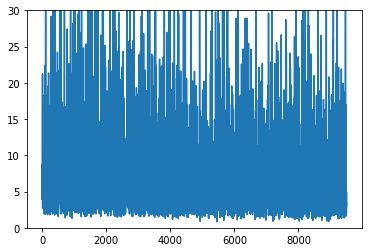

In [70]:
name = 'dqs_1_wm'
no_epochs = 10000
batch_size = 64
history = []

for e in range(no_epochs):
    mini_batch = wm_st.sample_train_data(batch_size)
    loss = wm_st.optimize(mini_batch)
    history.append(loss)
    if e % 500 == 0 and e > 5:
        clear_output(wait=True)
        plt.plot(history)
        plt.ylim(0, 30)
        plt.show()
        
        torch.save(wm_st.dqs_wm.state_dict(), "../../models/" + name)
        

In [82]:
no_steps = 10 ## number of steps simulated per episode (pendulum steps)

v_des = [0., 0]
v_init = [2.0*(np.random.rand() - 0.5), 1.5*(np.random.rand() - 0.5)]
# v_init = [0, 0.0

print(v_init)
state = env_main.reset_env([0.0, 0.0, ht, v_init[0], v_init[1], 0.0], v_des, no_steps*(2*step_time + air_time))
epi_cost = 0
for n in range(no_steps):
    terrain = 0.00
    q_xy = wm_st.predict_q_xy(state, terrain)
    action = wm_st.compute_opt_action(q_xy)
    next_state, cost, done = env_main.step_env(action, step_time, air_time)
    wm_action = wm_st.predict_q(state)[1]
    print(action, wm_action)

    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
print("showing episode...")
# env_main.show_episode(5)
# env_main.show_episode_side(5)

[-0.7116920089193577, -0.6779145990738769]
[2 0 0] [2. 0. 0.]
[6 8 0] [6. 8. 0.]
[3 6 0] [3. 6. 0.]
[4 0 0] [4. 0. 0.]
[6 8 0] [6. 8. 0.]
[2 1 0] [2. 1. 0.]
[4 6 0] [4. 5. 0.]
[3 8 0] [4. 6. 0.]
[6 0 0] [6. 0. 0.]
[5 6 0] [5. 6. 0.]
showing episode...
